# GODAS
https://catalog.pangeo.io/browse/master/ocean/GODAS/

https://www.psl.noaa.gov//data/gridded/data.godas.html

In [7]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [8]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7668b6ae941f4450a1a80be6f4c8e4a8 Dashboard: /services/dask-gateway/clusters/prod.7668b6ae941f4450a1a80be6f4c8e4a8/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
ds = xr.open_zarr(mapping, consolidated=True)

In [4]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [5]:
coords_roll = coords.roll(lon=500, lon_u=500)
ds_roll = ds.roll(lon=500, lon_u=500)

<ipython-input-5-ed45c25d685c>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_roll = coords.roll(lon=500, lon_u=500)
<ipython-input-5-ed45c25d685c>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_roll = ds.roll(lon=500, lon_u=500)


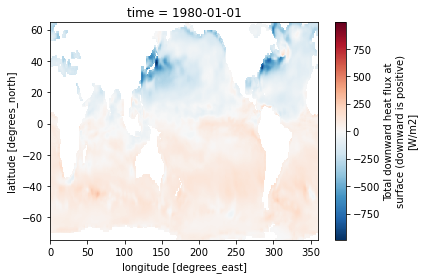

In [8]:
ds.thflx[0].plot()

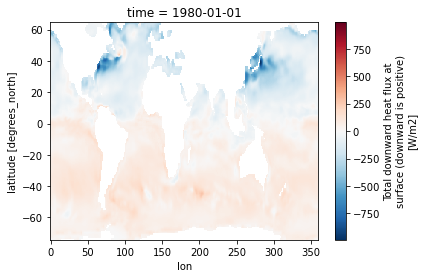

In [7]:
ds_roll.thflx[0].drop('lon').plot()

In [69]:
ds_roll.lon.isel(lon=170)

<xarray.DataArray 'lon' ()>
array(30.5, dtype=float32)
Coordinates:
    lon      float32 30.5
Attributes:
    GridType:       Cylindrical Equidistant Projection Grid
    actual_range:   [0.5, 359.5]
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [22]:
ds_roll.lon_u.isel(lon_u=74)

<xarray.DataArray 'lon_u' ()>
array(295., dtype=float32)
Coordinates:
    lon_u    float32 295.0
Attributes:
    GridType:       Cylindrical Equidistant Projection Grid
    actual_range:   [1.0, 360.0]
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [6]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-74.16667
upper_lat = 37 #-61.83
left_lon =  75 #295.5
right_lon = 170 #30.5

lower_lat_u = 0 #-74.0
upper_lat_u = 36 #-62.0
left_lon_u = 74 #295.0
right_lon_u = 169 #30.0

In [7]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat), lat_u=slice(lower_lat_u, upper_lat_u))
lon_range = dict(lon=slice(left_lon, right_lon), lon_u=slice(left_lon_u, right_lon_u))

lat_range_no_face = dict(lat=slice(lower_lat, upper_lat))
lon_range_no_face = dict(lon=slice(left_lon, right_lon))

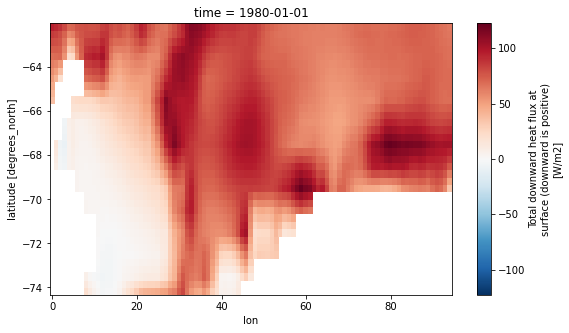

In [40]:
ds_roll.thflx[0].isel(**lat_range_no_face, **lon_range_no_face).drop('lon').plot(figsize=(9,5))

In [8]:
ds_wg = ds_roll.isel(**lat_range, **lon_range)
coords_wg = coords_roll.isel(**lat_range, **lon_range)

In [23]:
u_transport_right = (ds_wg.ucur * coords_wg.lat_u * coords_wg.lon_u * coords_wg.level).isel(lon_u=-1)
u_transport_left = (ds_wg.ucur * coords_wg.lat_u * coords_wg.lon_u * coords_wg.level).isel(lon_u=0)

v_transport = (ds_wg.vcur * coords_wg.lat_u * coords_wg.lon_u * coords_wg.level).isel(lat_u=-1)

Text(0.5, 1.0, 'V transport')

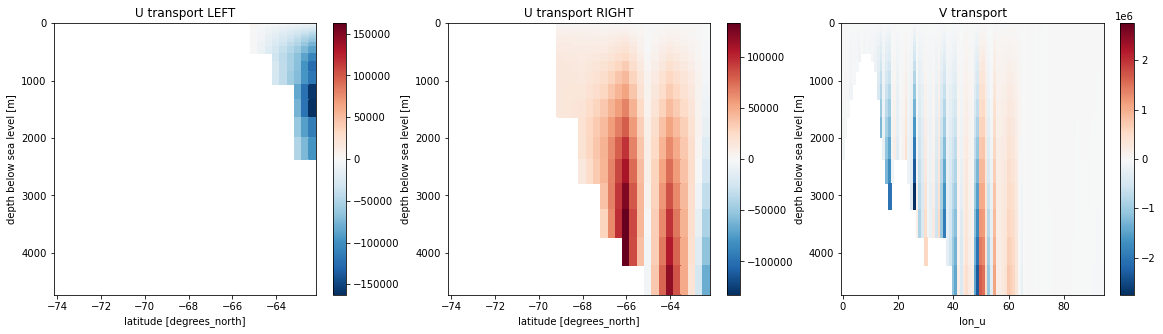

In [46]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

u_transport_left[0].plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT')
u_transport_right[0].plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT')
v_transport[0].drop('lon_u').plot(yincrease=False, ax=ax2)
ax2.set_title('V transport');

In [20]:
coords_wg.level

<xarray.DataArray 'level' (level: 40)>
array([   5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,   95.,
        105.,  115.,  125.,  135.,  145.,  155.,  165.,  175.,  185.,  195.,
        205.,  215.,  225.,  238.,  262.,  303.,  366.,  459.,  584.,  747.,
        949., 1193., 1479., 1807., 2174., 2579., 3016., 3483., 3972., 4478.],
      dtype=float32)
Coordinates:
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
Attributes:
    actual_range:  [5.0, 4478.0]
    axis:          Z
    long_name:     depth below sea level
    positive:      down
    units:         m

#### What can we compute with GODAS ds?
- [ ] surf flux
- [ ] sw flux
- [ ] lin_fs_correction
- [ ] adv flux
- [ ] diff flux
- [ ] total tendency